## Logistic Regression

### Notebook #3

## Table of Contents
1) <a href="#count" id="top">Count Vectorizer</a>
2) <a href="#tfidf">TFIDF</a>
3) <a href="#union">Union</a>
4) <a href="#conc">Conclusion</a>


## Intro

In this notebook we will be using a custom tokenizer to tokenize the comments and vectorizing them using both `CountVectorizer` and `TFIDF`. We will be running logistic regression on both vectors separately as well as a combination of the two. This is moslty and introduction and an extension of the EDA and preprocessing, so any optimizations of the `Logistic Regression` model will be minimal. We will explore other models using these same vectors in other notebooks as well as using `Word2Vec` and `BERT Tokenizer` to create word embeddings.



**A brief (but important) footnote**

From this point forward, we will be working with a sample of the original full dataset, which consited of ~1 million comments. This sample is exactly a quarter of the original total, with the distribution of the target variable remaining the same as in the original.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None, 'max_colwidth', 250)

import regex as re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gravi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# reading in csv
reddit = pd.read_csv('sample_comments.csv', index_col=[0])

In [3]:
# verification
reddit.head()

,label,comment
139484,0,Nope.
638093,0,Donde esta la biblioteca?
662570,0,I feel bad for the mummy... not even the minions want to get close to him :(
652534,1,"The Pirate Bay, of course!"
411846,1,That's exactly how multiple photographers ended up on the pavement; they tripped.


In [4]:
# looking at random sample
reddit.sample(25, random_state=42)

,label,comment
43529,1,"""excuse me while i use my white privilege to pay the same price everyone does for a steak at the store and cook it on my white privilege stove and marinate it in my racist salt and oppressed pepper and Worcestershire sauce and cook it medium priv..."
570138,1,Big fry before voting no!
848865,0,And shoulders
882540,1,Clearly OP wanted his cards to bend
603900,1,yeah sometimes i have trouble pressing E aswell
881241,1,You can never fault a perfectly constructed argument.
795227,1,THE CHILDREN!
186891,0,"Press ""X"" to pay respects."
493704,1,Ribery is a good one
200760,1,He's not using a controller what a noob


Now that our data is officially ready for preprocessing, we will conduct a `train/test split` before tokenizing and vectorizing our data.

In [8]:
# setting X and y
X = reddit['comment']
y = reddit['label']

In [9]:
# first split into test and remainder
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [10]:
# second split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size = 0.25, random_state=42)

    Below is our custom tokenizer function, which will do 5 things:
    - remove numbers
    - remove punctuation
    - split comments into individual words (tokens)
    - stem the tokens down to their root forms
    - and remove stopwords (words that hold little semantic meaning)

In [14]:
#instantiating stemmer and stop words
stemmer = nltk.stem.PorterStemmer()
stop_words = stopwords.words('english')

# custom tokenizer function
def tokenizer(sentence):
    
    sentence = re.sub("\d+", "", sentence) #filtering out numbers
         
    
    # removing punctuation and setting to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()
        
    
    # splitting sentence into words
    words_list = sentence.split(' ')
    
    tokens = [] # list to be filled with tokens
    
    
    # removing stopwords and any empty strings
    for word in words_list:
        if (not word in stop_words) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            tokens.append(stemmed_word)

    return tokens

## <a href="#top" id="count">Count Vectorizer</a>

Here we have our `CountVectorizer` function, which will use our custom tokenizer to create vectors for the most frequent 1500 words in our dataset.
We will be fitting our data to our training set, and transforming all 3 of `train`, `test`, and `val`(idation)

In [15]:
# instantiating count vectorizer with custom tokenizer
count_vector = CountVectorizer(min_df=25, tokenizer=tokenizer, max_features=1500, dtype=np.int8)

# fitting to train and transforming
count_vector.fit(X_train)
train_vectors = count_vector.transform(X_train)

# transforming to val and test
val_vectors = count_vector.transform(X_val)
test_vectors = count_vector.transform(X_test)

In [16]:
# turning tokens + vectors into dataframe
train_vector_df = pd.DataFrame(columns= count_vector.get_feature_names_out(), data=train_vectors.toarray())

# checking result
train_vector_df.head()

,abil,abl,abort,absolut,abus,accept,access,accord,account,accur,across,act,action,activ,actual,ad,add,addict,admit,adult,advic,affect,afford,age,ago,agre,ah,ahead,aim,aint,air,album,alcohol,alien,aliv,allow,almost,alon,along,alreadi,alright,also,altern,alway,amaz,america,american,amirit,amount,amp,angri,anim,announc,annoy,anoth,answer,anymor,anyon,anyth,anyway,apart,app,appar,appear,appl,appli,appreci,appropri,area,arent,argu,argument,arm,armi,armor,around,arrest,art,articl,artist,asian,ask,ass,assault,asshol,assum,atheist,attack,attempt,attent,attract,australia,avail,averag,avoid,aw,awar,away,awesom,b,babi,back,bad,bag,balanc,ball,ban,bank,bar,base,basic,batteri,battl,bear,beat,beauti,becom,beer,begin,behind,believ,benefit,berni,besid,best,bet,beta,better,big,bigger,biggest,bike,bill,bit,bitch,black,blame,blind,block,blood,blow,blue,board,bodi,bomb,book,boot,bore,born,boss,bot,bother,bottl,bottom,bought,bowl,box,boy,brain,brand,break,bring,british,bro,broke,broken,brother,brought,brown,buddi,buff,bug,build,built,bullet,bullshit,bunch,burn,bush,busi,butt,button,buy,c,call,came,camera,camp,campaign,canada,canadian,cancer,candid,cannot,cant,cap,capit,car,card,care,career,carri,case,cash,casual,cat,catch,caught,caus,center,certain,certainli,challeng,champion,chanc,chang,channel,charact,charg,cheap,cheat,check,chees,chicken,child,children,china,chines,choic,choos,christian,christma,church,citi,citizen,civil,claim,class,classic,clean,clear,clearli,click,clinton,close,cloth,club,coach,code,cold,collect,colleg,color,come,comic,comment,commi,commit,common,commun,communist,compani,compar,competit,complain,complet,comput,concern,confirm,confus,connect,conserv,consid,consol,conspiraci,construct,content,continu,contract,contribut,control,convers,convinc,cool,cop,copi,corner,corpor,correct,corrupt,cost,could,couldnt,count,countri,coupl,cours,court,cover,crap,crash,crazi,creat,credit,creepi,cri,crime,crimin,critic,cross,cultur,cup,current,custom,cut,cute,cuz,da,dad,daili,damag,damn,danger,dare,dark,dat,data,date,day,de,dead,deal,death,debat,decent,decid,decis,deck,deep,defend,defens,definit,degre,delet,demand,democraci,democrat,depend,depress,deserv,design,destroy,develop,dick,didnt,die,differ,difficult,direct,dirti,disagre,discuss,disgust,dlc,doctor,doesnt,dog,dollar,donald,donat,done,dont,door,doubl,doubt,download,downvot,draft,dragon,draw,dream,dress,drink,drive,driver,drop,drug,drunk,dude,due,duh,dumb,dunno,e,earli,earth,easi,easier,easili,east,eat,econom,economi,edit,educ,effect,effort,egg,eh,either,elect,els,em,email,emot,employe,end,enemi,energi,engin,english,enjoy,enough,entir,episod,equal,especi,etc,eu,europ,european,even,event,ever,everi,everybodi,everyon,everyth,everywher,evid,evil,exact,exactli,exampl,excel,except,excit,exclus,excus,exist,expect,expens,experi,expert,explain,extra,extrem,eye,f,face,facebook,fact,fail,fair,faith,fake,fall,fals,famili,fan,fantast,far,farm,fast,faster,fat,father,fault,favorit,fear,featur,feed,feel,felt,femal,feminist,field,fight,figur,file,fill,film,filthi,final,find,fine,finger,finish,fire,first,fit,five,fix,flag,flair,fli,flip,folk,follow,food,footbal,forc,foreign,forev,forget,forgot,form,forward,found,four,fox,fp,frame,free,freedom,french,friend,front,fuck,fuckin,full,fun,fund,funni,futur,g,ga,gain,game,garbag,gave,gay,gb,gear,gender,gener,german,germani,get,giant,gif,girl,girlfriend,give,given,glad,glass,global,go,goal,god,goe,gold,gone,gonna,good,googl,got,gotta,gotten,govern,grab,graphic,great,greatest,green,ground,group,grow,guess,guilti,gun,guy,ha,hack,haha,hair,half,hand,handl,hang,happen,happi,hard,harder,hasnt,hat,hate,havent,he,head,health,healthi,hear,heard,heart,heat,hed,hell,help,hero,hey,hide,high,higher,hilari,hillari,hire,histori,hit,hitler,hmm,hold,hole,holi,home,honest,honestli,hope,horribl,hot,hour,hous,huge,huh,human,hurt,hype,ice,id,idea,idiot,idk,ignor,ill,illeg,im,imag,imagin,immedi,immigr,imo,impli,import,imposs,impress,improv,includ,increas,incred,inde,individu,industri,in

In [17]:
# verifying shape and checking memory usage
train_vector_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142131 entries, 0 to 142130
Columns: 1500 entries, abil to zero
dtypes: int8(1500)
memory usage: 203.3 MB


In [19]:
# turning validation set into dataframe
val_vector_df = pd.DataFrame(columns= count_vector.get_feature_names_out(), data=val_vectors.toarray())

val_vector_df.head()

,abil,abl,abort,absolut,abus,accept,access,accord,account,accur,across,act,action,activ,actual,ad,add,addict,admit,adult,advic,affect,afford,age,ago,agre,ah,ahead,aim,aint,air,album,alcohol,alien,aliv,allow,almost,alon,along,alreadi,alright,also,altern,alway,amaz,america,american,amirit,amount,amp,angri,anim,announc,annoy,anoth,answer,anymor,anyon,anyth,anyway,apart,app,appar,appear,appl,appli,appreci,appropri,area,arent,argu,argument,arm,armi,armor,around,arrest,art,articl,artist,asian,ask,ass,assault,asshol,assum,atheist,attack,attempt,attent,attract,australia,avail,averag,avoid,aw,awar,away,awesom,b,babi,back,bad,bag,balanc,ball,ban,bank,bar,base,basic,batteri,battl,bear,beat,beauti,becom,beer,begin,behind,believ,benefit,berni,besid,best,bet,beta,better,big,bigger,biggest,bike,bill,bit,bitch,black,blame,blind,block,blood,blow,blue,board,bodi,bomb,book,boot,bore,born,boss,bot,bother,bottl,bottom,bought,bowl,box,boy,brain,brand,break,bring,british,bro,broke,broken,brother,brought,brown,buddi,buff,bug,build,built,bullet,bullshit,bunch,burn,bush,busi,butt,button,buy,c,call,came,camera,camp,campaign,canada,canadian,cancer,candid,cannot,cant,cap,capit,car,card,care,career,carri,case,cash,casual,cat,catch,caught,caus,center,certain,certainli,challeng,champion,chanc,chang,channel,charact,charg,cheap,cheat,check,chees,chicken,child,children,china,chines,choic,choos,christian,christma,church,citi,citizen,civil,claim,class,classic,clean,clear,clearli,click,clinton,close,cloth,club,coach,code,cold,collect,colleg,color,come,comic,comment,commi,commit,common,commun,communist,compani,compar,competit,complain,complet,comput,concern,confirm,confus,connect,conserv,consid,consol,conspiraci,construct,content,continu,contract,contribut,control,convers,convinc,cool,cop,copi,corner,corpor,correct,corrupt,cost,could,couldnt,count,countri,coupl,cours,court,cover,crap,crash,crazi,creat,credit,creepi,cri,crime,crimin,critic,cross,cultur,cup,current,custom,cut,cute,cuz,da,dad,daili,damag,damn,danger,dare,dark,dat,data,date,day,de,dead,deal,death,debat,decent,decid,decis,deck,deep,defend,defens,definit,degre,delet,demand,democraci,democrat,depend,depress,deserv,design,destroy,develop,dick,didnt,die,differ,difficult,direct,dirti,disagre,discuss,disgust,dlc,doctor,doesnt,dog,dollar,donald,donat,done,dont,door,doubl,doubt,download,downvot,draft,dragon,draw,dream,dress,drink,drive,driver,drop,drug,drunk,dude,due,duh,dumb,dunno,e,earli,earth,easi,easier,easili,east,eat,econom,economi,edit,educ,effect,effort,egg,eh,either,elect,els,em,email,emot,employe,end,enemi,energi,engin,english,enjoy,enough,entir,episod,equal,especi,etc,eu,europ,european,even,event,ever,everi,everybodi,everyon,everyth,everywher,evid,evil,exact,exactli,exampl,excel,except,excit,exclus,excus,exist,expect,expens,experi,expert,explain,extra,extrem,eye,f,face,facebook,fact,fail,fair,faith,fake,fall,fals,famili,fan,fantast,far,farm,fast,faster,fat,father,fault,favorit,fear,featur,feed,feel,felt,femal,feminist,field,fight,figur,file,fill,film,filthi,final,find,fine,finger,finish,fire,first,fit,five,fix,flag,flair,fli,flip,folk,follow,food,footbal,forc,foreign,forev,forget,forgot,form,forward,found,four,fox,fp,frame,free,freedom,french,friend,front,fuck,fuckin,full,fun,fund,funni,futur,g,ga,gain,game,garbag,gave,gay,gb,gear,gender,gener,german,germani,get,giant,gif,girl,girlfriend,give,given,glad,glass,global,go,goal,god,goe,gold,gone,gonna,good,googl,got,gotta,gotten,govern,grab,graphic,great,greatest,green,ground,group,grow,guess,guilti,gun,guy,ha,hack,haha,hair,half,hand,handl,hang,happen,happi,hard,harder,hasnt,hat,hate,havent,he,head,health,healthi,hear,heard,heart,heat,hed,hell,help,hero,hey,hide,high,higher,hilari,hillari,hire,histori,hit,hitler,hmm,hold,hole,holi,home,honest,honestli,hope,horribl,hot,hour,hous,huge,huh,human,hurt,hype,ice,id,idea,idiot,idk,ignor,ill,illeg,im,imag,imagin,immedi,immigr,imo,impli,import,imposs,impress,improv,includ,increas,incred,inde,individu,industri,in

In [20]:
# test into dataframe
test_vector_df = pd.DataFrame(columns= count_vector.get_feature_names_out(), data=test_vectors.toarray())

test_vector_df.head()

,abil,abl,abort,absolut,abus,accept,access,accord,account,accur,across,act,action,activ,actual,ad,add,addict,admit,adult,advic,affect,afford,age,ago,agre,ah,ahead,aim,aint,air,album,alcohol,alien,aliv,allow,almost,alon,along,alreadi,alright,also,altern,alway,amaz,america,american,amirit,amount,amp,angri,anim,announc,annoy,anoth,answer,anymor,anyon,anyth,anyway,apart,app,appar,appear,appl,appli,appreci,appropri,area,arent,argu,argument,arm,armi,armor,around,arrest,art,articl,artist,asian,ask,ass,assault,asshol,assum,atheist,attack,attempt,attent,attract,australia,avail,averag,avoid,aw,awar,away,awesom,b,babi,back,bad,bag,balanc,ball,ban,bank,bar,base,basic,batteri,battl,bear,beat,beauti,becom,beer,begin,behind,believ,benefit,berni,besid,best,bet,beta,better,big,bigger,biggest,bike,bill,bit,bitch,black,blame,blind,block,blood,blow,blue,board,bodi,bomb,book,boot,bore,born,boss,bot,bother,bottl,bottom,bought,bowl,box,boy,brain,brand,break,bring,british,bro,broke,broken,brother,brought,brown,buddi,buff,bug,build,built,bullet,bullshit,bunch,burn,bush,busi,butt,button,buy,c,call,came,camera,camp,campaign,canada,canadian,cancer,candid,cannot,cant,cap,capit,car,card,care,career,carri,case,cash,casual,cat,catch,caught,caus,center,certain,certainli,challeng,champion,chanc,chang,channel,charact,charg,cheap,cheat,check,chees,chicken,child,children,china,chines,choic,choos,christian,christma,church,citi,citizen,civil,claim,class,classic,clean,clear,clearli,click,clinton,close,cloth,club,coach,code,cold,collect,colleg,color,come,comic,comment,commi,commit,common,commun,communist,compani,compar,competit,complain,complet,comput,concern,confirm,confus,connect,conserv,consid,consol,conspiraci,construct,content,continu,contract,contribut,control,convers,convinc,cool,cop,copi,corner,corpor,correct,corrupt,cost,could,couldnt,count,countri,coupl,cours,court,cover,crap,crash,crazi,creat,credit,creepi,cri,crime,crimin,critic,cross,cultur,cup,current,custom,cut,cute,cuz,da,dad,daili,damag,damn,danger,dare,dark,dat,data,date,day,de,dead,deal,death,debat,decent,decid,decis,deck,deep,defend,defens,definit,degre,delet,demand,democraci,democrat,depend,depress,deserv,design,destroy,develop,dick,didnt,die,differ,difficult,direct,dirti,disagre,discuss,disgust,dlc,doctor,doesnt,dog,dollar,donald,donat,done,dont,door,doubl,doubt,download,downvot,draft,dragon,draw,dream,dress,drink,drive,driver,drop,drug,drunk,dude,due,duh,dumb,dunno,e,earli,earth,easi,easier,easili,east,eat,econom,economi,edit,educ,effect,effort,egg,eh,either,elect,els,em,email,emot,employe,end,enemi,energi,engin,english,enjoy,enough,entir,episod,equal,especi,etc,eu,europ,european,even,event,ever,everi,everybodi,everyon,everyth,everywher,evid,evil,exact,exactli,exampl,excel,except,excit,exclus,excus,exist,expect,expens,experi,expert,explain,extra,extrem,eye,f,face,facebook,fact,fail,fair,faith,fake,fall,fals,famili,fan,fantast,far,farm,fast,faster,fat,father,fault,favorit,fear,featur,feed,feel,felt,femal,feminist,field,fight,figur,file,fill,film,filthi,final,find,fine,finger,finish,fire,first,fit,five,fix,flag,flair,fli,flip,folk,follow,food,footbal,forc,foreign,forev,forget,forgot,form,forward,found,four,fox,fp,frame,free,freedom,french,friend,front,fuck,fuckin,full,fun,fund,funni,futur,g,ga,gain,game,garbag,gave,gay,gb,gear,gender,gener,german,germani,get,giant,gif,girl,girlfriend,give,given,glad,glass,global,go,goal,god,goe,gold,gone,gonna,good,googl,got,gotta,gotten,govern,grab,graphic,great,greatest,green,ground,group,grow,guess,guilti,gun,guy,ha,hack,haha,hair,half,hand,handl,hang,happen,happi,hard,harder,hasnt,hat,hate,havent,he,head,health,healthi,hear,heard,heart,heat,hed,hell,help,hero,hey,hide,high,higher,hilari,hillari,hire,histori,hit,hitler,hmm,hold,hole,holi,home,honest,honestli,hope,horribl,hot,hour,hous,huge,huh,human,hurt,hype,ice,id,idea,idiot,idk,ignor,ill,illeg,im,imag,imagin,immedi,immigr,imo,impli,import,imposs,impress,improv,includ,increas,incred,inde,individu,industri,in

Now that we have vectorized our text data, we will be running a first pass through our logistic regression model with just our `train` and `val`

In [22]:
# instantiating logreg, setting max_iter
logreg = LogisticRegression(max_iter=5000, random_state=42, n_jobs=4)

# fitting to train set
logreg.fit(train_vector_df, y_train)

# scoring train, val
print(f'Train score: {logreg.score(train_vector_df, y_train)}')
print(f'Val score: {logreg.score(val_vector_df, y_val)}')


Train score: 0.6645559378320001
Val score: 0.6537211363924185


    Not a bad result for the first pass through logistic regression with nothing but text data. Given that there is an (almost) perfect 50/50 split between our `sarcastic` and `non sarcastic` labels, our model is performing significantly better than random chance.

    Below we will run a loop to try and optimize our `C` value which serves to regularize our training data in an effort to make better predictions on new data.

    In our case, having vectors that resemble one-hot encoding, and having a validation score 1% below our training score, there is not much need for regularization. Unfortunately `Logistic Regression` does not afford much else in the way of hyper parameters and though it performs decently well, will likely not be the best model for our data.

In [24]:
# instantiating empty lists 
train_acc = []
val_acc = []

# setting c range
c_range = np.array([0.001,0.01, 0.1, 1, 10, 100, 1000])

# looping through c range to find best c
for c in c_range:
    # instantiating logreg with different c's
    logreg = LogisticRegression(C=c, max_iter=5000, random_state=42, n_jobs=4)
    
    #fitting to train
    logreg.fit(train_vector_df, y_train)
    
    #appending scores to lists
    train_acc.append(logreg.score(train_vector_df, y_train))
    val_acc.append(logreg.score(val_vector_df, y_val))

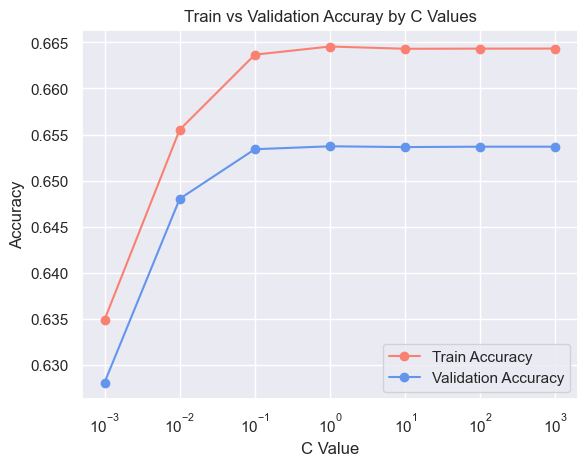

In [25]:
# plotting results of best c search
plt.figure()

plt.plot(c_range, train_acc, color='salmon', marker='o', label='Train Accuracy')
plt.plot(c_range, val_acc, color='cornflowerblue', marker='o', label='Validation Accuracy')
plt.title('Train vs Validation Accuray by C Values')
plt.ylabel('Accuracy')
plt.xlabel('C Value')
plt.xscale('log')

plt.legend()
plt.show()

    As expected, the regularization did not do much to improve our scores, as the scores plateau around a `C` value of 1, which is the default.

Having run our logreg model, we can take this opportunity to plot out the top 20 highest (and lowers) predictors of sarcasm based on our model.

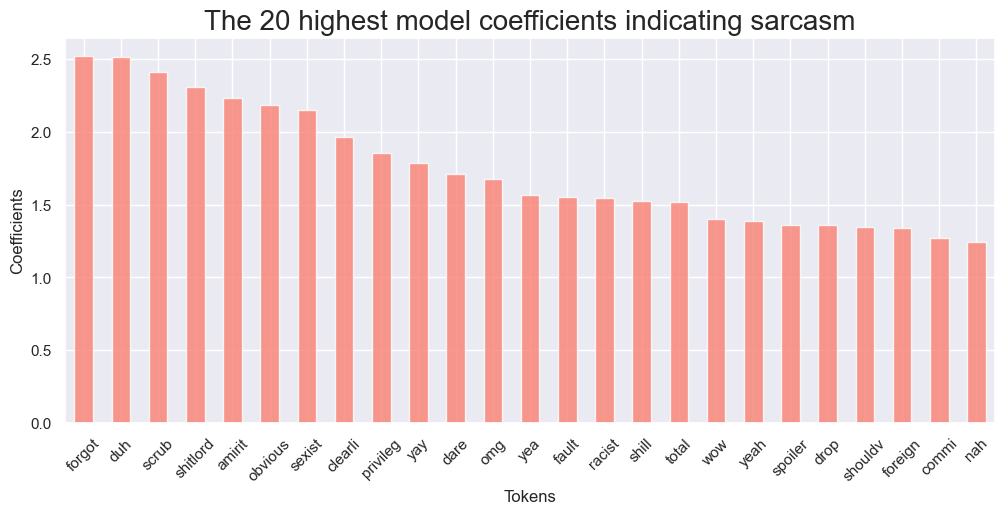

In [30]:
# plotting top sarcasm predictor words
sarcastic_predictors = pd.DataFrame({"coef": logreg.coef_[0,0:]},
    index=logreg.feature_names_in_[0:]).sort_values("coef", ascending=False).head(25)

sarcastic_predictors.plot(kind="bar", figsize=(12, 5), legend=False, color='salmon', alpha=0.8)
plt.title("The 20 highest model coefficients indicating sarcasm", fontsize=20)
plt.ylabel("Coefficients")
plt.xlabel('Tokens')
plt.xticks(rotation=45)
plt.show()

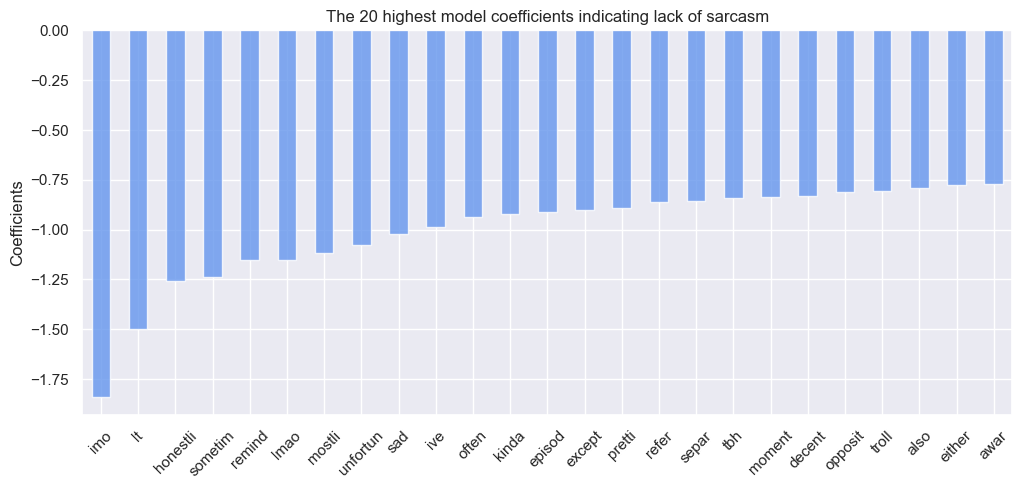

In [39]:
# plotting bottom sarcasm predictor words
non_sarcastic_predictors = pd.DataFrame({"coef": logreg.coef_[0,0:]},
    index=logreg.feature_names_in_[0:]).sort_values("coef", ascending=True).head(25)

non_sarcastic_predictors.plot(kind="bar", figsize=(12, 5), legend=False, color='cornflowerblue', alpha=0.8)
plt.title("The 20 highest model coefficients indicating lack of sarcasm")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

    We can see some encouraging results in that we find words in our lists that have logical relationships with our target variable.

#### Sarcastic
    - duh
    - shitlord
    - yea(h)
    - amirite

#### Non Sarcastic
    - honestli
    - unfortun
    - tbh
    

---------------------------------------------------------------------------------------------------------------------------------------------------------

## <a href="#top" id= "tfidf">TFIDF</a>

We will now use the same custom tokenizer, but vectorize our tokens using `TFIDF` to see if we can find a difference in the results of the `Logistic Regression` 

In [31]:
# using custom tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=25,
                        tokenizer=tokenizer, max_features=1500, dtype=np.float32)

tfidf.fit(X_train)# fitting to train

# transforming train, test, val
X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

C:\Users\gravi\anaconda3\envs\sarcasm\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [32]:
# transforming train to df
train_tfidf = pd.DataFrame(columns= tfidf.get_feature_names_out(), data=X_train_tfidf.toarray())

train_tfidf.head()

,abil,abl,abort,absolut,abus,accept,access,accord,account,accur,across,act,action,activ,actual,ad,add,addict,admit,adult,advic,affect,afford,age,ago,agre,ah,ahead,aim,aint,air,album,alcohol,alien,aliv,allow,almost,alon,along,alreadi,alright,also,altern,alway,amaz,america,american,amirit,amount,amp,angri,anim,announc,annoy,anoth,answer,anymor,anyon,anyth,anyway,apart,app,appar,appear,appl,appli,appreci,appropri,area,arent,argu,argument,arm,armi,armor,around,arrest,art,articl,artist,asian,ask,ass,assault,asshol,assum,atheist,attack,attempt,attent,attract,australia,avail,averag,avoid,aw,awar,away,awesom,b,babi,back,bad,bag,balanc,ball,ban,bank,bar,base,basic,batteri,battl,bear,beat,beauti,becom,beer,begin,behind,believ,benefit,berni,besid,best,bet,beta,better,big,bigger,biggest,bike,bill,bit,bitch,black,blame,blind,block,blood,blow,blue,board,bodi,bomb,book,boot,bore,born,boss,bot,bother,bottl,bottom,bought,bowl,box,boy,brain,brand,break,bring,british,bro,broke,broken,brother,brought,brown,buddi,buff,bug,build,built,bullet,bullshit,bunch,burn,bush,busi,butt,button,buy,c,call,came,camera,camp,campaign,canada,canadian,cancer,candid,cannot,cant,cap,capit,car,card,care,career,carri,case,cash,casual,cat,catch,caught,caus,center,certain,certainli,challeng,champion,chanc,chang,channel,charact,charg,cheap,cheat,check,chees,chicken,child,children,china,chines,choic,choos,christian,christma,church,citi,citizen,civil,claim,class,classic,clean,clear,clearli,click,clinton,close,cloth,club,coach,code,cold,collect,colleg,color,come,comic,comment,commi,commit,common,commun,communist,compani,compar,competit,complain,complet,comput,concern,confirm,confus,connect,conserv,consid,consol,conspiraci,construct,content,continu,contract,contribut,control,convers,convinc,cool,cop,copi,corner,corpor,correct,corrupt,cost,could,couldnt,count,countri,coupl,cours,court,cover,crap,crash,crazi,creat,credit,creepi,cri,crime,crimin,critic,cross,cultur,cup,current,custom,cut,cute,cuz,da,dad,daili,damag,damn,danger,dare,dark,dat,data,date,day,de,dead,deal,death,debat,decent,decid,decis,deck,deep,defend,defens,definit,degre,delet,demand,democraci,democrat,depend,depress,deserv,design,destroy,develop,dick,didnt,die,differ,difficult,direct,dirti,disagre,discuss,disgust,dlc,doctor,doesnt,dog,dollar,donald,donat,done,dont,door,doubl,doubt,download,downvot,draft,dragon,draw,dream,dress,drink,drive,driver,drop,drug,drunk,dude,due,duh,dumb,dunno,e,earli,earth,easi,easier,easili,east,eat,econom,economi,edit,educ,effect,effort,egg,eh,either,elect,els,em,email,emot,employe,end,enemi,energi,engin,english,enjoy,enough,entir,episod,equal,especi,etc,eu,europ,european,even,event,ever,everi,everybodi,everyon,everyth,everywher,evid,evil,exact,exactli,exampl,excel,except,excit,exclus,excus,exist,expect,expens,experi,expert,explain,extra,extrem,eye,f,face,facebook,fact,fail,fair,faith,fake,fall,fals,famili,fan,fantast,far,farm,fast,faster,fat,father,fault,favorit,fear,featur,feed,feel,felt,femal,feminist,field,fight,figur,file,fill,film,filthi,final,find,fine,finger,finish,fire,first,fit,five,fix,flag,flair,fli,flip,folk,follow,food,footbal,forc,foreign,forev,forget,forgot,form,forward,found,four,fox,fp,frame,free,freedom,french,friend,front,fuck,fuckin,full,fun,fund,funni,futur,g,ga,gain,game,garbag,gave,gay,gb,gear,gender,gener,german,germani,get,giant,gif,girl,girlfriend,give,given,glad,glass,global,go,goal,god,goe,gold,gone,gonna,good,googl,got,gotta,gotten,govern,grab,graphic,great,greatest,green,ground,group,grow,guess,guilti,gun,guy,ha,hack,haha,hair,half,hand,handl,hang,happen,happi,hard,harder,hasnt,hat,hate,havent,he,head,health,healthi,hear,heard,heart,heat,hed,hell,help,hero,hey,hide,high,higher,hilari,hillari,hire,histori,hit,hitler,hmm,hold,hole,holi,home,honest,honestli,hope,horribl,hot,hour,hous,huge,huh,human,hurt,hype,ice,id,idea,idiot,idk,ignor,ill,illeg,im,imag,imagin,immedi,immigr,imo,impli,import,imposs,impress,improv,includ,increas,incred,inde,individu,industri,in

In [33]:
# val to df
val_tfidf = pd.DataFrame(columns= tfidf.get_feature_names_out(), data=X_val_tfidf.toarray())

val_tfidf.head()

,abil,abl,abort,absolut,abus,accept,access,accord,account,accur,across,act,action,activ,actual,ad,add,addict,admit,adult,advic,affect,afford,age,ago,agre,ah,ahead,aim,aint,air,album,alcohol,alien,aliv,allow,almost,alon,along,alreadi,alright,also,altern,alway,amaz,america,american,amirit,amount,amp,angri,anim,announc,annoy,anoth,answer,anymor,anyon,anyth,anyway,apart,app,appar,appear,appl,appli,appreci,appropri,area,arent,argu,argument,arm,armi,armor,around,arrest,art,articl,artist,asian,ask,ass,assault,asshol,assum,atheist,attack,attempt,attent,attract,australia,avail,averag,avoid,aw,awar,away,awesom,b,babi,back,bad,bag,balanc,ball,ban,bank,bar,base,basic,batteri,battl,bear,beat,beauti,becom,beer,begin,behind,believ,benefit,berni,besid,best,bet,beta,better,big,bigger,biggest,bike,bill,bit,bitch,black,blame,blind,block,blood,blow,blue,board,bodi,bomb,book,boot,bore,born,boss,bot,bother,bottl,bottom,bought,bowl,box,boy,brain,brand,break,bring,british,bro,broke,broken,brother,brought,brown,buddi,buff,bug,build,built,bullet,bullshit,bunch,burn,bush,busi,butt,button,buy,c,call,came,camera,camp,campaign,canada,canadian,cancer,candid,cannot,cant,cap,capit,car,card,care,career,carri,case,cash,casual,cat,catch,caught,caus,center,certain,certainli,challeng,champion,chanc,chang,channel,charact,charg,cheap,cheat,check,chees,chicken,child,children,china,chines,choic,choos,christian,christma,church,citi,citizen,civil,claim,class,classic,clean,clear,clearli,click,clinton,close,cloth,club,coach,code,cold,collect,colleg,color,come,comic,comment,commi,commit,common,commun,communist,compani,compar,competit,complain,complet,comput,concern,confirm,confus,connect,conserv,consid,consol,conspiraci,construct,content,continu,contract,contribut,control,convers,convinc,cool,cop,copi,corner,corpor,correct,corrupt,cost,could,couldnt,count,countri,coupl,cours,court,cover,crap,crash,crazi,creat,credit,creepi,cri,crime,crimin,critic,cross,cultur,cup,current,custom,cut,cute,cuz,da,dad,daili,damag,damn,danger,dare,dark,dat,data,date,day,de,dead,deal,death,debat,decent,decid,decis,deck,deep,defend,defens,definit,degre,delet,demand,democraci,democrat,depend,depress,deserv,design,destroy,develop,dick,didnt,die,differ,difficult,direct,dirti,disagre,discuss,disgust,dlc,doctor,doesnt,dog,dollar,donald,donat,done,dont,door,doubl,doubt,download,downvot,draft,dragon,draw,dream,dress,drink,drive,driver,drop,drug,drunk,dude,due,duh,dumb,dunno,e,earli,earth,easi,easier,easili,east,eat,econom,economi,edit,educ,effect,effort,egg,eh,either,elect,els,em,email,emot,employe,end,enemi,energi,engin,english,enjoy,enough,entir,episod,equal,especi,etc,eu,europ,european,even,event,ever,everi,everybodi,everyon,everyth,everywher,evid,evil,exact,exactli,exampl,excel,except,excit,exclus,excus,exist,expect,expens,experi,expert,explain,extra,extrem,eye,f,face,facebook,fact,fail,fair,faith,fake,fall,fals,famili,fan,fantast,far,farm,fast,faster,fat,father,fault,favorit,fear,featur,feed,feel,felt,femal,feminist,field,fight,figur,file,fill,film,filthi,final,find,fine,finger,finish,fire,first,fit,five,fix,flag,flair,fli,flip,folk,follow,food,footbal,forc,foreign,forev,forget,forgot,form,forward,found,four,fox,fp,frame,free,freedom,french,friend,front,fuck,fuckin,full,fun,fund,funni,futur,g,ga,gain,game,garbag,gave,gay,gb,gear,gender,gener,german,germani,get,giant,gif,girl,girlfriend,give,given,glad,glass,global,go,goal,god,goe,gold,gone,gonna,good,googl,got,gotta,gotten,govern,grab,graphic,great,greatest,green,ground,group,grow,guess,guilti,gun,guy,ha,hack,haha,hair,half,hand,handl,hang,happen,happi,hard,harder,hasnt,hat,hate,havent,he,head,health,healthi,hear,heard,heart,heat,hed,hell,help,hero,hey,hide,high,higher,hilari,hillari,hire,histori,hit,hitler,hmm,hold,hole,holi,home,honest,honestli,hope,horribl,hot,hour,hous,huge,huh,human,hurt,hype,ice,id,idea,idiot,idk,ignor,ill,illeg,im,imag,imagin,immedi,immigr,imo,impli,import,imposs,impress,improv,includ,increas,incred,inde,individu,industri,in

In [34]:
# test to df
test_tfidf = pd.DataFrame(columns= tfidf.get_feature_names_out(), data=X_test_tfidf.toarray())

test_tfidf.head()

,abil,abl,abort,absolut,abus,accept,access,accord,account,accur,across,act,action,activ,actual,ad,add,addict,admit,adult,advic,affect,afford,age,ago,agre,ah,ahead,aim,aint,air,album,alcohol,alien,aliv,allow,almost,alon,along,alreadi,alright,also,altern,alway,amaz,america,american,amirit,amount,amp,angri,anim,announc,annoy,anoth,answer,anymor,anyon,anyth,anyway,apart,app,appar,appear,appl,appli,appreci,appropri,area,arent,argu,argument,arm,armi,armor,around,arrest,art,articl,artist,asian,ask,ass,assault,asshol,assum,atheist,attack,attempt,attent,attract,australia,avail,averag,avoid,aw,awar,away,awesom,b,babi,back,bad,bag,balanc,ball,ban,bank,bar,base,basic,batteri,battl,bear,beat,beauti,becom,beer,begin,behind,believ,benefit,berni,besid,best,bet,beta,better,big,bigger,biggest,bike,bill,bit,bitch,black,blame,blind,block,blood,blow,blue,board,bodi,bomb,book,boot,bore,born,boss,bot,bother,bottl,bottom,bought,bowl,box,boy,brain,brand,break,bring,british,bro,broke,broken,brother,brought,brown,buddi,buff,bug,build,built,bullet,bullshit,bunch,burn,bush,busi,butt,button,buy,c,call,came,camera,camp,campaign,canada,canadian,cancer,candid,cannot,cant,cap,capit,car,card,care,career,carri,case,cash,casual,cat,catch,caught,caus,center,certain,certainli,challeng,champion,chanc,chang,channel,charact,charg,cheap,cheat,check,chees,chicken,child,children,china,chines,choic,choos,christian,christma,church,citi,citizen,civil,claim,class,classic,clean,clear,clearli,click,clinton,close,cloth,club,coach,code,cold,collect,colleg,color,come,comic,comment,commi,commit,common,commun,communist,compani,compar,competit,complain,complet,comput,concern,confirm,confus,connect,conserv,consid,consol,conspiraci,construct,content,continu,contract,contribut,control,convers,convinc,cool,cop,copi,corner,corpor,correct,corrupt,cost,could,couldnt,count,countri,coupl,cours,court,cover,crap,crash,crazi,creat,credit,creepi,cri,crime,crimin,critic,cross,cultur,cup,current,custom,cut,cute,cuz,da,dad,daili,damag,damn,danger,dare,dark,dat,data,date,day,de,dead,deal,death,debat,decent,decid,decis,deck,deep,defend,defens,definit,degre,delet,demand,democraci,democrat,depend,depress,deserv,design,destroy,develop,dick,didnt,die,differ,difficult,direct,dirti,disagre,discuss,disgust,dlc,doctor,doesnt,dog,dollar,donald,donat,done,dont,door,doubl,doubt,download,downvot,draft,dragon,draw,dream,dress,drink,drive,driver,drop,drug,drunk,dude,due,duh,dumb,dunno,e,earli,earth,easi,easier,easili,east,eat,econom,economi,edit,educ,effect,effort,egg,eh,either,elect,els,em,email,emot,employe,end,enemi,energi,engin,english,enjoy,enough,entir,episod,equal,especi,etc,eu,europ,european,even,event,ever,everi,everybodi,everyon,everyth,everywher,evid,evil,exact,exactli,exampl,excel,except,excit,exclus,excus,exist,expect,expens,experi,expert,explain,extra,extrem,eye,f,face,facebook,fact,fail,fair,faith,fake,fall,fals,famili,fan,fantast,far,farm,fast,faster,fat,father,fault,favorit,fear,featur,feed,feel,felt,femal,feminist,field,fight,figur,file,fill,film,filthi,final,find,fine,finger,finish,fire,first,fit,five,fix,flag,flair,fli,flip,folk,follow,food,footbal,forc,foreign,forev,forget,forgot,form,forward,found,four,fox,fp,frame,free,freedom,french,friend,front,fuck,fuckin,full,fun,fund,funni,futur,g,ga,gain,game,garbag,gave,gay,gb,gear,gender,gener,german,germani,get,giant,gif,girl,girlfriend,give,given,glad,glass,global,go,goal,god,goe,gold,gone,gonna,good,googl,got,gotta,gotten,govern,grab,graphic,great,greatest,green,ground,group,grow,guess,guilti,gun,guy,ha,hack,haha,hair,half,hand,handl,hang,happen,happi,hard,harder,hasnt,hat,hate,havent,he,head,health,healthi,hear,heard,heart,heat,hed,hell,help,hero,hey,hide,high,higher,hilari,hillari,hire,histori,hit,hitler,hmm,hold,hole,holi,home,honest,honestli,hope,horribl,hot,hour,hous,huge,huh,human,hurt,hype,ice,id,idea,idiot,idk,ignor,ill,illeg,im,imag,imagin,immedi,immigr,imo,impli,import,imposs,impress,improv,includ,increas,incred,inde,individu,industri,in

In [35]:
# instantiating tfidf logreg
tfidf_logreg = LogisticRegression(max_iter=5000, random_state=42, n_jobs=4)

# fitting to train
tfidf_logreg.fit(train_tfidf, y_train)

# scoring train and validation
print(f'Train score: {tfidf_logreg.score(train_tfidf, y_train)}')
print(f'Val score: {tfidf_logreg.score(val_tfidf, y_val)}')

Train score: 0.6637046105353512
Val score: 0.6530035037359112


    Our scores are almost identical to the ones we got with the `CountVectorizer`. This may have something to do with the parameters that we set, namely `max_features` and `min_df` as `TFIDF` gives more weight to words that are infrequent. Including these parameters was a necessary step, however, as the unique tokens without filtering are north of 160k and would overwhelm both our model and our memory.

Let us see if there is any difference in the top (and bottom) predictors of sarcasm according to our TFIDF logreg model.

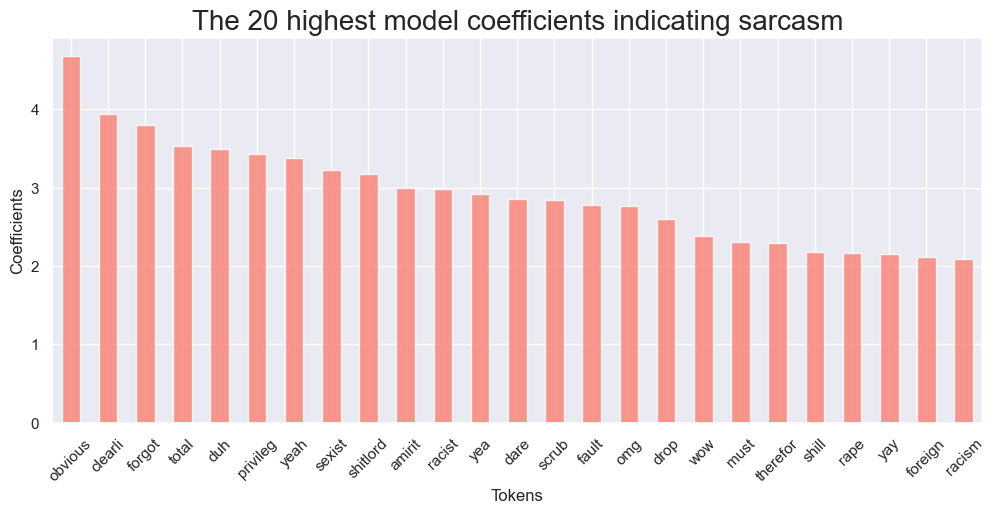

In [37]:
# plotting top sarcasm predictor words
sarcastic_predictors = pd.DataFrame({"coef": tfidf_logreg.coef_[0,0:]},
    index=tfidf_logreg.feature_names_in_[0:]).sort_values("coef", ascending=False).head(25)

sarcastic_predictors.plot(kind="bar", figsize=(12, 5), legend=False, color='salmon', alpha=0.8)
plt.title("The 20 highest model coefficients indicating sarcasm", fontsize=20)
plt.ylabel("Coefficients")
plt.xlabel('Tokens')
plt.xticks(rotation=45)
plt.show()

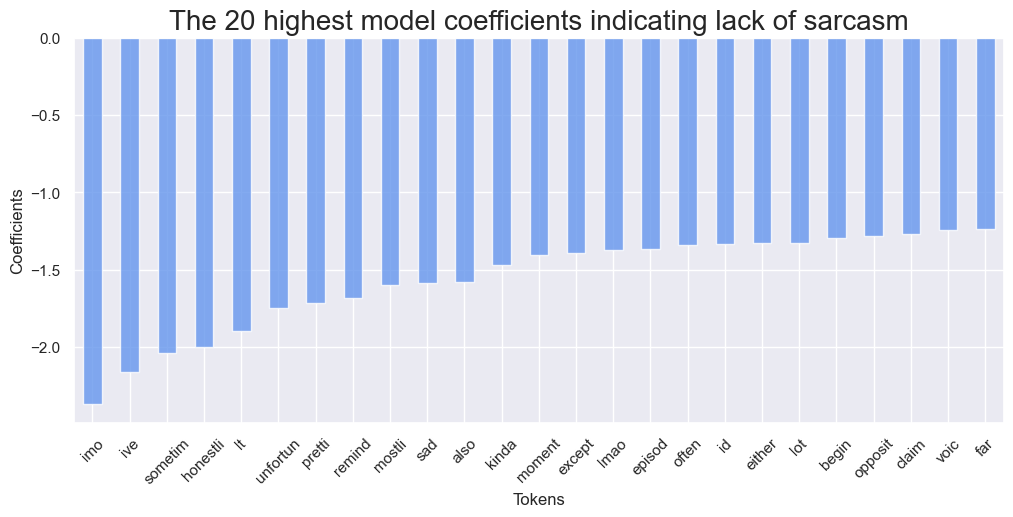

In [40]:
# plotting top sarcasm predictor words
non_sarcastic_predictors = pd.DataFrame({"coef": tfidf_logreg.coef_[0,0:]},
    index=tfidf_logreg.feature_names_in_[0:]).sort_values("coef", ascending=True).head(25)

non_sarcastic_predictors.plot(kind="bar", figsize=(12, 5), legend=False, color='cornflowerblue', alpha=0.8)
plt.title("The 20 highest model coefficients indicating lack of sarcasm", fontsize=20)
plt.ylabel("Coefficients")
plt.xlabel('Tokens')
plt.xticks(rotation=45)
plt.show()

    The top predictors are largely the same. There are a few new words in the top 20s, and the order is shuffled around a bit, but there is ultimately a lot of similarity between the `CountVectorizer` and `TFIDF` predictors.

## <a href="#top" id="union">Union</a>

Finally we will use `FeatureUnion` to combine both `CountVectorizer` and `TFIDF` into one model, aptly named "union".

In [36]:
# vectorizers which we will pass into FeatureUnion with unique prefixes
vectorizers = [('count_vect', CountVectorizer(min_df=25, tokenizer=tokenizer, max_features=750)),
               ('tfidf', TfidfVectorizer(min_df=25, tokenizer=tokenizer, max_features=750))]

# Creating feature union
featunion = FeatureUnion(vectorizers)

# Fitting and transforming train,test,val
train_tokens = featunion.fit_transform(X_train)
val_tokens = featunion.transform(X_val)
test_tokens = featunion.transform(X_test)





In [41]:
# turning train into dataframe
train_union = pd.DataFrame(data=train_tokens.todense(), columns=featunion.get_feature_names_out())

#confirming result
train_union.head()

,count_vect__abl,count_vect__absolut,count_vect__accept,count_vect__account,count_vect__act,count_vect__action,count_vect__actual,count_vect__ad,count_vect__add,count_vect__age,count_vect__ago,count_vect__agre,count_vect__ah,count_vect__allow,count_vect__almost,count_vect__alreadi,count_vect__also,count_vect__alway,count_vect__amaz,count_vect__america,count_vect__american,count_vect__amount,count_vect__amp,count_vect__anim,count_vect__anoth,count_vect__answer,count_vect__anymor,count_vect__anyon,count_vect__anyth,count_vect__anyway,count_vect__appar,count_vect__appl,count_vect__area,count_vect__arent,count_vect__argument,count_vect__arm,count_vect__around,count_vect__articl,count_vect__ask,count_vect__ass,count_vect__asshol,count_vect__assum,count_vect__attack,count_vect__away,count_vect__awesom,count_vect__babi,count_vect__back,count_vect__bad,count_vect__ball,count_vect__ban,count_vect__base,count_vect__basic,count_vect__beat,count_vect__beauti,count_vect__becom,count_vect__behind,count_vect__believ,count_vect__berni,count_vect__best,count_vect__bet,count_vect__better,count_vect__big,count_vect__bit,count_vect__bitch,count_vect__black,count_vect__blame,count_vect__blue,count_vect__bodi,count_vect__book,count_vect__bought,count_vect__box,count_vect__boy,count_vect__break,count_vect__bring,count_vect__bro,count_vect__brother,count_vect__build,count_vect__bullshit,count_vect__bunch,count_vect__burn,count_vect__busi,count_vect__buy,count_vect__c,count_vect__call,count_vect__came,count_vect__cant,count_vect__car,count_vect__card,count_vect__care,count_vect__carri,count_vect__case,count_vect__cat,count_vect__catch,count_vect__caus,count_vect__certainli,count_vect__chanc,count_vect__chang,count_vect__charact,count_vect__charg,count_vect__check,count_vect__child,count_vect__children,count_vect__choic,count_vect__christian,count_vect__citi,count_vect__claim,count_vect__class,count_vect__clear,count_vect__clearli,count_vect__clinton,count_vect__close,count_vect__colleg,count_vect__color,count_vect__come,count_vect__comment,count_vect__commun,count_vect__compani,count_vect__compar,count_vect__complain,count_vect__complet,count_vect__comput,count_vect__confirm,count_vect__consid,count_vect__content,count_vect__control,count_vect__cool,count_vect__cop,count_vect__correct,count_vect__cost,count_vect__could,count_vect__couldnt,count_vect__count,count_vect__countri,count_vect__coupl,count_vect__cours,count_vect__cover,count_vect__crazi,count_vect__creat,count_vect__crime,count_vect__cultur,count_vect__current,count_vect__cut,count_vect__damag,count_vect__damn,count_vect__dare,count_vect__date,count_vect__day,count_vect__dead,count_vect__deal,count_vect__death,count_vect__decid,count_vect__defens,count_vect__definit,count_vect__democrat,count_vect__deserv,count_vect__design,count_vect__destroy,count_vect__develop,count_vect__dick,count_vect__didnt,count_vect__die,count_vect__differ,count_vect__doesnt,count_vect__dog,count_vect__dollar,count_vect__done,count_vect__dont,count_vect__doubt,count_vect__downvot,count_vect__drink,count_vect__drive,count_vect__driver,count_vect__drop,count_vect__drug,count_vect__dude,count_vect__due,count_vect__duh,count_vect__dumb,count_vect__e,count_vect__earth,count_vect__easi,count_vect__easier,count_vect__eat,count_vect__effect,count_vect__either,count_vect__elect,count_vect__els,count_vect__end,count_vect__enemi,count_vect__engin,count_vect__english,count_vect__enjoy,count_vect__enough,count_vect__entir,count_vect__equal,count_vect__especi,count_vect__etc,count_vect__even,count_vect__ever,count_vect__everi,count_vect__everyon,count_vect__everyth,count_vect__evid,count_vect__evil,count_vect__exactli,count_vect__exampl,count_vect__except,count_vect__exist,count_vect__expect,count_vect__experi,count_vect__explain,count_vect__extra,count_vect__eye,count_vect__f,count_vect__face,count_vect__fact,count_vect__fail,count_vect__fair,count_vect__fake,count_vect__fall,count_vect__famili,count_vect__fan,count_vect__far,co

In [42]:
# checking shape
train_union.shape

(142131, 1500)

In [43]:
# validation into dataframe
val_union = pd.DataFrame(data=val_tokens.todense(), columns=featunion.get_feature_names_out())

val_union.head()

,count_vect__abl,count_vect__absolut,count_vect__accept,count_vect__account,count_vect__act,count_vect__action,count_vect__actual,count_vect__ad,count_vect__add,count_vect__age,count_vect__ago,count_vect__agre,count_vect__ah,count_vect__allow,count_vect__almost,count_vect__alreadi,count_vect__also,count_vect__alway,count_vect__amaz,count_vect__america,count_vect__american,count_vect__amount,count_vect__amp,count_vect__anim,count_vect__anoth,count_vect__answer,count_vect__anymor,count_vect__anyon,count_vect__anyth,count_vect__anyway,count_vect__appar,count_vect__appl,count_vect__area,count_vect__arent,count_vect__argument,count_vect__arm,count_vect__around,count_vect__articl,count_vect__ask,count_vect__ass,count_vect__asshol,count_vect__assum,count_vect__attack,count_vect__away,count_vect__awesom,count_vect__babi,count_vect__back,count_vect__bad,count_vect__ball,count_vect__ban,count_vect__base,count_vect__basic,count_vect__beat,count_vect__beauti,count_vect__becom,count_vect__behind,count_vect__believ,count_vect__berni,count_vect__best,count_vect__bet,count_vect__better,count_vect__big,count_vect__bit,count_vect__bitch,count_vect__black,count_vect__blame,count_vect__blue,count_vect__bodi,count_vect__book,count_vect__bought,count_vect__box,count_vect__boy,count_vect__break,count_vect__bring,count_vect__bro,count_vect__brother,count_vect__build,count_vect__bullshit,count_vect__bunch,count_vect__burn,count_vect__busi,count_vect__buy,count_vect__c,count_vect__call,count_vect__came,count_vect__cant,count_vect__car,count_vect__card,count_vect__care,count_vect__carri,count_vect__case,count_vect__cat,count_vect__catch,count_vect__caus,count_vect__certainli,count_vect__chanc,count_vect__chang,count_vect__charact,count_vect__charg,count_vect__check,count_vect__child,count_vect__children,count_vect__choic,count_vect__christian,count_vect__citi,count_vect__claim,count_vect__class,count_vect__clear,count_vect__clearli,count_vect__clinton,count_vect__close,count_vect__colleg,count_vect__color,count_vect__come,count_vect__comment,count_vect__commun,count_vect__compani,count_vect__compar,count_vect__complain,count_vect__complet,count_vect__comput,count_vect__confirm,count_vect__consid,count_vect__content,count_vect__control,count_vect__cool,count_vect__cop,count_vect__correct,count_vect__cost,count_vect__could,count_vect__couldnt,count_vect__count,count_vect__countri,count_vect__coupl,count_vect__cours,count_vect__cover,count_vect__crazi,count_vect__creat,count_vect__crime,count_vect__cultur,count_vect__current,count_vect__cut,count_vect__damag,count_vect__damn,count_vect__dare,count_vect__date,count_vect__day,count_vect__dead,count_vect__deal,count_vect__death,count_vect__decid,count_vect__defens,count_vect__definit,count_vect__democrat,count_vect__deserv,count_vect__design,count_vect__destroy,count_vect__develop,count_vect__dick,count_vect__didnt,count_vect__die,count_vect__differ,count_vect__doesnt,count_vect__dog,count_vect__dollar,count_vect__done,count_vect__dont,count_vect__doubt,count_vect__downvot,count_vect__drink,count_vect__drive,count_vect__driver,count_vect__drop,count_vect__drug,count_vect__dude,count_vect__due,count_vect__duh,count_vect__dumb,count_vect__e,count_vect__earth,count_vect__easi,count_vect__easier,count_vect__eat,count_vect__effect,count_vect__either,count_vect__elect,count_vect__els,count_vect__end,count_vect__enemi,count_vect__engin,count_vect__english,count_vect__enjoy,count_vect__enough,count_vect__entir,count_vect__equal,count_vect__especi,count_vect__etc,count_vect__even,count_vect__ever,count_vect__everi,count_vect__everyon,count_vect__everyth,count_vect__evid,count_vect__evil,count_vect__exactli,count_vect__exampl,count_vect__except,count_vect__exist,count_vect__expect,count_vect__experi,count_vect__explain,count_vect__extra,count_vect__eye,count_vect__f,count_vect__face,count_vect__fact,count_vect__fail,count_vect__fair,count_vect__fake,count_vect__fall,count_vect__famili,count_vect__fan,count_vect__far,co

In [44]:
# test into dataframe
test_union = pd.DataFrame(data = test_tokens.todense(), columns = featunion.get_feature_names_out())

test_union.head()

,count_vect__abl,count_vect__absolut,count_vect__accept,count_vect__account,count_vect__act,count_vect__action,count_vect__actual,count_vect__ad,count_vect__add,count_vect__age,count_vect__ago,count_vect__agre,count_vect__ah,count_vect__allow,count_vect__almost,count_vect__alreadi,count_vect__also,count_vect__alway,count_vect__amaz,count_vect__america,count_vect__american,count_vect__amount,count_vect__amp,count_vect__anim,count_vect__anoth,count_vect__answer,count_vect__anymor,count_vect__anyon,count_vect__anyth,count_vect__anyway,count_vect__appar,count_vect__appl,count_vect__area,count_vect__arent,count_vect__argument,count_vect__arm,count_vect__around,count_vect__articl,count_vect__ask,count_vect__ass,count_vect__asshol,count_vect__assum,count_vect__attack,count_vect__away,count_vect__awesom,count_vect__babi,count_vect__back,count_vect__bad,count_vect__ball,count_vect__ban,count_vect__base,count_vect__basic,count_vect__beat,count_vect__beauti,count_vect__becom,count_vect__behind,count_vect__believ,count_vect__berni,count_vect__best,count_vect__bet,count_vect__better,count_vect__big,count_vect__bit,count_vect__bitch,count_vect__black,count_vect__blame,count_vect__blue,count_vect__bodi,count_vect__book,count_vect__bought,count_vect__box,count_vect__boy,count_vect__break,count_vect__bring,count_vect__bro,count_vect__brother,count_vect__build,count_vect__bullshit,count_vect__bunch,count_vect__burn,count_vect__busi,count_vect__buy,count_vect__c,count_vect__call,count_vect__came,count_vect__cant,count_vect__car,count_vect__card,count_vect__care,count_vect__carri,count_vect__case,count_vect__cat,count_vect__catch,count_vect__caus,count_vect__certainli,count_vect__chanc,count_vect__chang,count_vect__charact,count_vect__charg,count_vect__check,count_vect__child,count_vect__children,count_vect__choic,count_vect__christian,count_vect__citi,count_vect__claim,count_vect__class,count_vect__clear,count_vect__clearli,count_vect__clinton,count_vect__close,count_vect__colleg,count_vect__color,count_vect__come,count_vect__comment,count_vect__commun,count_vect__compani,count_vect__compar,count_vect__complain,count_vect__complet,count_vect__comput,count_vect__confirm,count_vect__consid,count_vect__content,count_vect__control,count_vect__cool,count_vect__cop,count_vect__correct,count_vect__cost,count_vect__could,count_vect__couldnt,count_vect__count,count_vect__countri,count_vect__coupl,count_vect__cours,count_vect__cover,count_vect__crazi,count_vect__creat,count_vect__crime,count_vect__cultur,count_vect__current,count_vect__cut,count_vect__damag,count_vect__damn,count_vect__dare,count_vect__date,count_vect__day,count_vect__dead,count_vect__deal,count_vect__death,count_vect__decid,count_vect__defens,count_vect__definit,count_vect__democrat,count_vect__deserv,count_vect__design,count_vect__destroy,count_vect__develop,count_vect__dick,count_vect__didnt,count_vect__die,count_vect__differ,count_vect__doesnt,count_vect__dog,count_vect__dollar,count_vect__done,count_vect__dont,count_vect__doubt,count_vect__downvot,count_vect__drink,count_vect__drive,count_vect__driver,count_vect__drop,count_vect__drug,count_vect__dude,count_vect__due,count_vect__duh,count_vect__dumb,count_vect__e,count_vect__earth,count_vect__easi,count_vect__easier,count_vect__eat,count_vect__effect,count_vect__either,count_vect__elect,count_vect__els,count_vect__end,count_vect__enemi,count_vect__engin,count_vect__english,count_vect__enjoy,count_vect__enough,count_vect__entir,count_vect__equal,count_vect__especi,count_vect__etc,count_vect__even,count_vect__ever,count_vect__everi,count_vect__everyon,count_vect__everyth,count_vect__evid,count_vect__evil,count_vect__exactli,count_vect__exampl,count_vect__except,count_vect__exist,count_vect__expect,count_vect__experi,count_vect__explain,count_vect__extra,count_vect__eye,count_vect__f,count_vect__face,count_vect__fact,count_vect__fail,count_vect__fair,count_vect__fake,count_vect__fall,count_vect__famili,count_vect__fan,count_vect__far,co

In [46]:
# running logreg on both CountVectorizer and TFIDF together
union_logreg = LogisticRegression(max_iter=5000, random_state=42, n_jobs=4)

union_logreg.fit(train_union, y_train)

print(f'Train Score: {union_logreg.score(train_union, y_train)}')
print(f'Validation Score: {union_logreg.score(val_union, y_val)}')


Train Score: 0.660594803385609
Validation Score: 0.6464603824559922


    Once again our `train` score hovers around 66 and our `val` score, around 65. Whether together or separately, both `CountVectorizer` and `TFIDF` performed almost identically on the `Logistic Regression`.

--------------------------------------------------------------------------------------------------------------------------------------------------

## <a href="#top" id="conc">Conclusion<a/>

Although the relationship between text data can have a lot of nuance and non-linearity, the `Logistic Regression` model is not necessarily a bad fit - especially not for binary classification. Sarcasm is a tough cookie to crack as it requires a lot of context present both within the text, around the text, and even outside of the text all together. It is possible that in this case the `Logistic Regression` model was limited not by itself, but by the tokens and vectors it was presented with. `CountVectorizer` and `TFIDF` may not be the tools for the job. We will, however, try to run a few more models using these vectorizers before moving on to word embeddings.

In the following notebook, we will reintroduce the `parent comments` to see if they can offer us a little help with the context that we require.